# Generating Fake Faces with DCGAN


# CelebFaces Attributes (CelebA) Dataset
https://www.kaggle.com/jessicali9530/celeba-dataset

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images

In [2]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [3]:
attributes = pd.read_csv('dataset/list_attr_celeba.csv')
bboxes = pd.read_csv('dataset/list_bbox_celeba.csv')
partition = pd.read_csv('dataset/list_eval_partition.csv')
landmarks = pd.read_csv('dataset/list_landmarks_align_celeba.csv')
base_directory = 'dataset\\img_align_celeba'
#base_directory = 'D:\GAN\GAN_Facedataset'

In [4]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('dataset/img_align_celeba/*.jpg'):
    images.append(mpimg.imread(img_path))
images = images[:20]
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    #fig.tight_layout() 
    plt.imshow(image)

<Figure size 2000x1000 with 0 Axes>

# Reading list_landmarks_align_celeba.csv

In [5]:
landmarks_df = pd.read_csv('dataset/list_landmarks_align_celeba.csv')
landmarks_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


# Plotting Landmarks

In [6]:
paths_to_images = 'dataset\\img_align_celeba\000002.jpg'


#current_landmarks = landmarks.query('image_id == "{}"'.format(paths_to_images.split('\\')[-1]))
#print("Current landmark ; ",current_landmarks)


eye_x, eye_y, eye_w, eye_h = np.array(landmarks.iloc[:, 1:5])[0]
nose_x,nose_y,leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y = np.array(landmarks.iloc[:, 5:])[0]

left_eye = (eye_x, eye_y)
right_eye = (eye_w, eye_h)
nose = (nose_x + 10,nose_y)
left_mounth = (leftmouth_x, leftmouth_y)
right_mounth = (rightmouth_x, rightmouth_y)

example_image = cv2.imread(paths_to_images)
original_image = example_image.copy()


example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

example_image = cv2.line(example_image, left_eye, right_eye, (0, 255, 255),1)
example_image = cv2.line(example_image, left_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, right_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, nose, left_mounth,(0, 255, 255), 1)
example_image = cv2.line(example_image, nose, right_mounth, (0, 255, 255), 1)

plt.figure(figsize = (10, 20))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Image with landmarks')
plt.imshow(example_image)



AttributeError: 'NoneType' object has no attribute 'copy'

# Reading Bounding Box coordinates list_bbox_celeba.csv  

In [6]:
bboxes_df = pd.read_csv('dataset/list_bbox_celeba.csv')
bboxes_df.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


# Plotting Bounding Box Cordinates

     image_id  x_1  y_1  width  height
1  000002.jpg   72   94    221     306


NameError: name 'original_image' is not defined

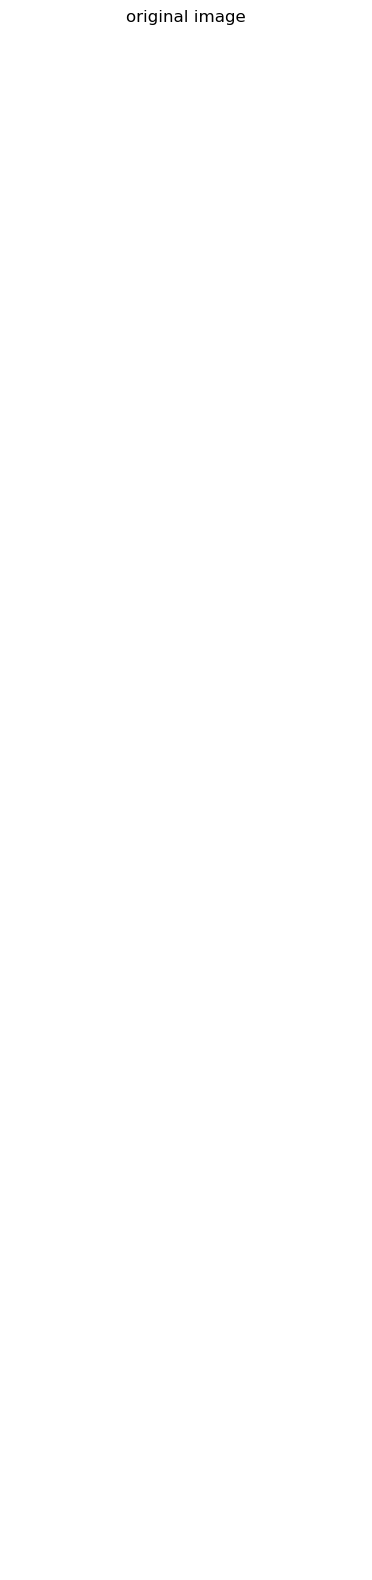

In [7]:
current_bbox = bboxes.query('image_id == "{}"'.format(paths_to_images.split('\\')[-1]))
print(current_bbox)
x, y, w, h = np.array(current_bbox.iloc[:, 1:])[0]

example_image = cv2.rectangle(example_image, (x - w, y ), (w , h ), (0, 255, 255), 1)

plt.figure(figsize = (10, 20))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Image with bbox and landmarks')
plt.imshow(example_image)


# Reading list_eval_partition.csv

In [8]:
partition_df = pd.read_csv('dataset/list_eval_partition.csv')
partition_df.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


# Types of Partitions

In [9]:
partition_df['partition'].value_counts()
# Have 3 partitions  (partition is just recomended parameter of dataset distribution)

0    162770
2     19962
1     19867
Name: partition, dtype: int64

In [10]:
train_images = partition.query('partition == 0')
valid_images = partition.query('partition == 1')
test_images = partition.query('partition == 2')



# Reading list_attr_celeba.csv

In [11]:
attributes_df = pd.read_csv('dataset/list_attr_celeba.csv')
attributes_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


# Create the discriminator
It maps a 64x64 image to a binary classification score.

After receiving all the images, fake and real, the Discriminator returns probabilities, a number in the range of 0 and 1, 1 representing a prediction of authenticity and 0 representing fake


The research shows that image generation is possible with relatively low input quality (64x64 pixels) 

In [12]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [13]:
# 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [14]:

dataset = keras.preprocessing.image_dataset_from_directory(
    "dataset", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 251 files belonging to 1 classes.


# Override train_step

In [15]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Create a callback that periodically saves generated images


In [16]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()

# Train the end-to-end model

 Adam optimizer with a learning rate of 0.002. This is as per the original research paper on DCGANs. 
 Link: https://arxiv.org/abs/1511.06434

In [ ]:
epochs = 35  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/35
8/8 [==============================] - ETA: 0s - d_loss: 0.6600 - g_loss: 0.8259

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

8/8 [==============================] - 74s 9s/step - d_loss: 0.6600 - g_loss: 0.8259
Epoch 2/35
5/8 [=================>............] - ETA: 26s - d_loss: 0.6151 - g_loss: 0.8702

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('output_samples/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 20
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    #fig.tight_layout() 
    plt.imshow(image)